In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import optuna 
from optuna.trial import TrialState 
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import os
import warnings
warnings.filterwarnings("ignore")

In [3]:
# --- 1. 配置和超参数 ---
CONFIG = {
    'data_path': '/home/hmd24/project/TOC_Warning_System/data/processed/TOC_dataset.xlsx',
    'output_feature': 'Endpoint',
    'input_features': ['BD', 'PW', 'DI', 'RO', 'MD'],
    'sequence_length': 24,
    'forecast_horizon': 1,
    'train_ratio': 0.8,
    'batch_size': 64, # 初始值，Optuna会探索
    'num_epochs': 200,
    'learning_rate': 0.001, # 初始值，Optuna会探索
    'early_stopping_patience': 20, 
    'warning_threshold': 0.65,
    'model_save_path': '../checkpoints/best_tcn_lstm_attention_toc_model.pth',
    'results_dir': '../results/plots/',
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    
    # Scaler
    'scaler_type': 'Standard', # <-- 修改为 Standard
    
    # L2 正则化强度
    'weight_decay': 1e-5, # <-- 初始值，Optuna会探索

    # TCN specific parameters (初始值，Optuna会探索)
    'tcn_num_channels': [30, 30, 30], 
    'tcn_kernel_size': 3,             
    'tcn_dropout': 0.3,               
    
    # LSTM specific parameters (初始值，Optuna会探索)
    'lstm_hidden_size': 64,          
    'lstm_num_layers': 2,            
    'lstm_dropout': 0.3,             

    # Optuna specific parameters
    'n_trials': 50, # Optuna 试验次数
    'timeout': 7200 # Optuna 运行时间上限 (秒)，这里设置为 100 分钟
}

# 确保结果目录存在
os.makedirs(CONFIG['results_dir'], exist_ok=True)
os.makedirs(os.path.dirname(CONFIG['model_save_path']), exist_ok=True)

print(f"Using device: {CONFIG['device']}")

Using device: cuda


In [129]:
# # --- 2. 数据加载与处理 (优化后，避免时序数据泄露) ---

# # 2.1 加载数据
# df = pd.read_excel(CONFIG['data_path'])
# print(f"原始数据形状: {df.shape}")
# print(f"数据列名: {df.columns.tolist()}")

# df['timestamp'] = pd.to_datetime(df['timestamp']) # 确保时间戳是 datetime 类型
# df = df.sort_values(by='timestamp').reset_index(drop=True)
# print("数据已根据 'timestamp' 列进行时序排序。")

# # 2.2 特征选择
# features_df = df[CONFIG['input_features'] + [CONFIG['output_feature']]]

# # 2.3 划分训练集和测试集 (按时间顺序)
# train_size = int(len(features_df) * CONFIG['train_ratio'])
# train_df = features_df.iloc[:train_size]
# test_df = features_df.iloc[train_size:]

# print(f"训练集形状: {train_df.shape}")
# print(f"测试集形状: {test_df.shape}")

# # 2.4 数据归一化 (使用MinMaxScaler，只用训练集数据fit scaler)
# # 初始化scaler
# scaler = MinMaxScaler()

# # 仅用训练数据拟合scaler，避免数据泄露
# scaler.fit(train_df)

# # 对训练集和测试集分别进行转换
# train_scaled = scaler.transform(train_df)
# test_scaled = scaler.transform(test_df)

# print(f"训练集归一化后形状: {train_scaled.shape}")
# print(f"测试集归一化后形状: {test_scaled.shape}")

# # 保存scaler，以便后续对预测结果进行反归一化 (只对输出特征反归一化)
# # 这里需要特殊处理，因为scaler是对所有特征fit的
# # output_scaler 只用来反归一化输出特征
# output_feature_index_in_df = features_df.columns.get_loc(CONFIG['output_feature'])
# # output_scaler 复制原始scaler中对应输出特征的 min_ 和 scale_
# output_scaler = MinMaxScaler()
# # 为了正确反归一化，我们需要一个和训练时一样的scaler状态
# # 重新拟合一个单特征的scaler来保存其状态，或者直接保存/加载整个scaler
# # 更稳妥的方式是模拟一个单特征的scaler，并设置其min_和scale_
# output_scaler.min_, output_scaler.scale_ = scaler.min_[output_feature_index_in_df], scaler.scale_[output_feature_index_in_df]

In [4]:
# --- 2. 数据加载与处理 (修改 scaler) ---
# 这部分代码在 Optuna 目标函数外部执行一次，作为全局数据
df = pd.read_excel(CONFIG['data_path'])
print(f"原始数据形状: {df.shape}")
print(f"数据列名: {df.columns.tolist()}")

if 'timestamp' in df.columns:
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df = df.sort_values(by='timestamp').reset_index(drop=True)
    print("数据已根据 'timestamp' 列进行时序排序。")
else:
    print("警告: 未找到 'timestamp' 列，请确保数据已按时间顺序排列。")

features_df = df[CONFIG['input_features'] + [CONFIG['output_feature']]]
train_size = int(len(features_df) * CONFIG['train_ratio'])
train_df = features_df.iloc[:train_size]
test_df = features_df.iloc[train_size:]

# 根据配置选择 scaler
if CONFIG['scaler_type'] == 'MinMax':
    scaler = MinMaxScaler()
    print("使用 MinMaxScaler 进行数据归一化。")
elif CONFIG['scaler_type'] == 'Standard':
    scaler = StandardScaler() # <-- 修改为 StandardScaler
    print("使用 StandardScaler 进行数据标准化。")
else:
    raise ValueError("scaler_type 必须是 'MinMax' 或 'Standard'")

scaler.fit(train_df)
train_scaled = scaler.transform(train_df)
test_scaled = scaler.transform(test_df)

# Output scaler 仍然使用 MinMaxScaler 以便反归一化到原始范围
output_scaler = MinMaxScaler() 
# 对于 StandardScaler，output_scaler 的 min_ 和 scale_ 属性需要特别处理
# 但因为我们只关心 output_feature 的反归一化，MinMaxScaler 仍然可以用于这个特定列的范围反转换
# 更严谨的做法是：如果目标变量也用 StandardScaler 归一化，那么反归一化需要 StandardScaler 的 mean_ 和 scale_
# 这里为了简化并保持输出范围，我们保持 output_scaler 为 MinMaxScaler，但它只作用于 output_feature 的那个维度
# 确保 output_feature_index_in_df 正确
output_feature_index_in_df = features_df.columns.get_loc(CONFIG['output_feature'])
output_scaler.min_ = scaler.min_[output_feature_index_in_df] if CONFIG['scaler_type'] == 'MinMax' else None # 对于StandardScaler，MinMax的min_不适用
output_scaler.scale_ = scaler.scale_[output_feature_index_in_df] if CONFIG['scaler_type'] == 'MinMax' else None # 对于StandardScaler，MinMax的scale_不适用

# 如果使用 StandardScaler，output_scaler 的反归一化需要其自身的 mean_ 和 scale_
# 所以，我们单独为 output_feature 创建一个 StandardScaler
if CONFIG['scaler_type'] == 'Standard':
    output_feature_scaler = StandardScaler()
    # 仅用训练集的目标变量进行拟合
    output_feature_scaler.fit(train_df[[CONFIG['output_feature']]])
else: # MinMaxScaler
    output_feature_scaler = output_scaler # 沿用之前的 output_scaler 实例

print(f"训练集形状: {train_scaled.shape}")
print(f"测试集形状: {test_scaled.shape}")

原始数据形状: (10054, 7)
数据列名: ['timestamp', 'BD', 'PW', 'DI', 'RO', 'MD', 'Endpoint']
数据已根据 'timestamp' 列进行时序排序。
使用 StandardScaler 进行数据标准化。
训练集形状: (8043, 6)
测试集形状: (2011, 6)


In [5]:
# --- 3. Dataset 类定义 ---
class TOCDataset(Dataset):
    def __init__(self, data, input_features_idx, output_feature_idx, sequence_length, forecast_horizon):
        self.data = data # 归一化后的数据 (numpy array)
        self.input_features_idx = input_features_idx
        self.output_feature_idx = output_feature_idx
        self.sequence_length = sequence_length
        self.forecast_horizon = forecast_horizon

    def __len__(self):
        # 确保有足够的序列长度和预测未来步长
        return len(self.data) - self.sequence_length - self.forecast_horizon + 1

    def __getitem__(self, idx):
        # input_seq: 过去 sequence_length 步的输入特征
        # TCN 的输入通常是 (batch_size, channels/features, sequence_length)
        input_seq = self.data[idx : idx + self.sequence_length, self.input_features_idx].T # 转置为 (features, sequence_length)

        # target_toc: 预测目标 (未来 forecast_horizon 步的终端TOC)
        # 考虑到是预警系统，通常是预测未来一个时间步或当前时间步的TOC
        # 这里假设是预测序列结束点 (idx + sequence_length - 1) 之后 forecast_horizon 步的TOC
        target_toc = self.data[idx + self.sequence_length + self.forecast_horizon -1, self.output_feature_idx]

        return torch.tensor(input_seq, dtype=torch.float32), torch.tensor(target_toc, dtype=torch.float32)

# 获取输入和输出特征在 `features_df` 中的索引
input_feature_indices = [features_df.columns.get_loc(col) for col in CONFIG['input_features']]
output_feature_index = features_df.columns.get_loc(CONFIG['output_feature'])

train_dataset = TOCDataset(train_scaled, input_feature_indices, output_feature_index, CONFIG['sequence_length'], CONFIG['forecast_horizon'])
test_dataset = TOCDataset(test_scaled, input_feature_indices, output_feature_index, CONFIG['sequence_length'], CONFIG['forecast_horizon'])

train_loader = DataLoader(train_dataset, batch_size=CONFIG['batch_size'], shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=CONFIG['batch_size'], shuffle=False)

print(f"训练集样本数: {len(train_dataset)}")
print(f"测试集样本数: {len(test_dataset)}")

训练集样本数: 8019
测试集样本数: 1987


In [132]:
# # --- 4. TCN 模型定义 ---
# class Chomp1d(nn.Module):
#     def __init__(self, chomp_size):
#         super(Chomp1d, self).__init__()
#         self.chomp_size = chomp_size

#     def forward(self, x):
#         return x[:, :, :-self.chomp_size].contiguous()

# class TemporalBlock(nn.Module):
#     def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
#         super(TemporalBlock, self).__init__()
#         # 第一个因果卷积层
#         self.conv1 = nn.Conv1d(n_inputs, n_outputs, kernel_size,
#                                stride=stride, padding=padding, dilation=dilation)
#         self.chomp1 = Chomp1d(padding) # 移除右侧填充以实现因果性
#         self.relu1 = nn.ReLU()
#         self.dropout1 = nn.Dropout(dropout)

#         # 第二个因果卷积层
#         self.conv2 = nn.Conv1d(n_outputs, n_outputs, kernel_size,
#                                stride=stride, padding=padding, dilation=dilation)
#         self.chomp2 = Chomp1d(padding)
#         self.relu2 = nn.ReLU()
#         self.dropout2 = nn.Dropout(dropout)

#         # 残差连接：如果输入和输出通道数不一致，需要1x1卷积进行匹配
#         self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1,
#                                  self.conv2, self.chomp2, self.relu2, self.dropout2)
#         self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
#         self.relu = nn.ReLU()

#     def forward(self, x):
#         out = self.net(x)
#         res = x if self.downsample is None else self.downsample(x)
#         return self.relu(out + res) # 残差连接

# class TemporalConvNet(nn.Module):
#     def __init__(self, num_inputs, num_channels, kernel_size=2, dropout=0.2):
#         super(TemporalConvNet, self).__init__()
#         layers = []
#         num_levels = len(num_channels) # 网络层数
#         for i in range(num_levels):
#             dilation_size = 2 ** i # 膨胀系数指数增长
#             in_channels = num_inputs if i == 0 else num_channels[i-1]
#             out_channels = num_channels[i]
#             # 计算padding，确保输出序列长度和输入相同
#             padding = (kernel_size - 1) * dilation_size 
#             layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
#                                      padding=padding, dropout=dropout)]

#         self.tcn = nn.Sequential(*layers)
#         self.linear = nn.Linear(num_channels[-1], 1) # 最终输出层，映射到单TOC值

#     def forward(self, x):
#         # x shape: (batch_size, num_features, sequence_length)
#         # TCN层输出
#         output = self.tcn(x)
#         # 取最后一个时间步的特征进行线性预测 (通常TCN会保留序列长度，这里我们取最后一个时间步的特征)
#         # 或者，如果TCN的最后一层输出是 (batch_size, num_channels[-1], sequence_length)
#         # 我们可以对整个序列的最后一个输出进行线性映射
#         return self.linear(output[:, :, -1]).squeeze(1) # output[:, :, -1] 形状为 (batch_size, num_channels[-1])


# # 实例化模型
# input_size = len(CONFIG['input_features']) # 5个工艺段TOC
# model = TemporalConvNet(input_size, CONFIG['num_channels'], 
#                         kernel_size=CONFIG['kernel_size'], 
#                         dropout=CONFIG['dropout']).to(CONFIG['device'])
# print(f"模型结构:\n{model}")

In [6]:
# --- 4. TCN-LSTM-Attention 模型定义 (作为独立函数，以便 Optuna 调用) ---

# TCN 辅助模块 (保持不变)
class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size
    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()

class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        self.conv1 = nn.Conv1d(n_inputs, n_outputs, kernel_size, stride=stride, padding=padding, dilation=dilation)
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)
        self.conv2 = nn.Conv1d(n_outputs, n_outputs, kernel_size, stride=stride, padding=padding, dilation=dilation)
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)
        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1,
                                 self.conv2, self.chomp2, self.relu2, self.dropout2)
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()
    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)

class TemporalConvNet(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=2, dropout=0.2):
        super(TemporalConvNet, self).__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            padding = (kernel_size - 1) * dilation_size 
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
                                     padding=padding, dropout=dropout)]
        self.tcn = nn.Sequential(*layers)
    def forward(self, x):
        return self.tcn(x)

class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.attn = nn.Linear(hidden_size * 2, hidden_size)
        self.v = nn.Linear(hidden_size, 1, bias=False)
    def forward(self, rnn_outputs, final_hidden_state):
        final_hidden_state_expanded = final_hidden_state.unsqueeze(1).repeat(1, rnn_outputs.size(1), 1)
        combined = torch.cat((rnn_outputs, final_hidden_state_expanded), dim=2)
        attn_weights = self.v(torch.tanh(self.attn(combined)))
        attn_weights = F.softmax(attn_weights, dim=1)
        context_vector = torch.sum(attn_weights * rnn_outputs, dim=1)
        return context_vector, attn_weights

class TOCPredictor_TCN_LSTM_Attention(nn.Module):
    def __init__(self, input_size, tcn_num_channels, tcn_kernel_size, tcn_dropout,
                 lstm_hidden_size, lstm_num_layers, lstm_dropout):
        super(TOCPredictor_TCN_LSTM_Attention, self).__init__()
        self.tcn = TemporalConvNet(input_size, tcn_num_channels, tcn_kernel_size, tcn_dropout)
        tcn_output_channels = tcn_num_channels[-1] 
        self.lstm = nn.LSTM(tcn_output_channels, lstm_hidden_size, lstm_num_layers, 
                            batch_first=True, dropout=lstm_dropout if lstm_num_layers > 1 else 0)
        self.attention = Attention(lstm_hidden_size)
        self.fc = nn.Linear(lstm_hidden_size, 1)

    def forward(self, x):
        tcn_output = self.tcn(x)
        lstm_input = tcn_output.permute(0, 2, 1)
        rnn_outputs, (hn, cn) = self.lstm(lstm_input)
        final_hidden_state = hn[-1, :, :]
        context_vector, _ = self.attention(rnn_outputs, final_hidden_state)
        out = self.fc(context_vector)
        return out.squeeze(1)

In [7]:
# --- 5. Optuna 目标函数 ---
def objective(trial):
    # 定义超参数搜索空间
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
    weight_decay = trial.suggest_loguniform('weight_decay', 1e-6, 1e-3) 
    tcn_num_channels = trial.suggest_categorical('tcn_num_channels', [[20, 20, 20], [30, 30, 30], [40, 40, 40], [40, 80, 160]])
    tcn_kernel_size = trial.suggest_categorical('tcn_kernel_size', [2, 3, 4])
    tcn_dropout = trial.suggest_float('tcn_dropout', 0.3, 0.5)
    lstm_hidden_size = trial.suggest_categorical('lstm_hidden_size', [64, 128, 256])
    lstm_num_layers = trial.suggest_int('lstm_num_layers', 1, 3, 5)
    lstm_dropout = trial.suggest_float('lstm_dropout', 0.3, 0.5)
    
    # 确保 lstm_dropout 在单层 LSTM 时为 0
    if lstm_num_layers == 1:
        lstm_dropout = 0.0

    # 创建 DataLoader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # 实例化模型
    input_size = len(CONFIG['input_features'])
    model = TOCPredictor_TCN_LSTM_Attention(
        input_size=input_size,
        tcn_num_channels=tcn_num_channels,
        tcn_kernel_size=tcn_kernel_size,
        tcn_dropout=tcn_dropout,
        lstm_hidden_size=lstm_hidden_size,
        lstm_num_layers=lstm_num_layers,
        lstm_dropout=lstm_dropout
    ).to(CONFIG['device'])

    # 定义损失函数和优化器
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    best_val_loss = float('inf')
    epochs_no_improve = 0

    # 训练循环
    for epoch in range(CONFIG['num_epochs']):
        model.train()
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(CONFIG['device']), targets.to(CONFIG['device'])
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
        
        # 验证阶段
        model.eval()
        val_running_loss = 0.0
        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs, targets = inputs.to(CONFIG['device']), targets.to(CONFIG['device'])
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_running_loss += loss.item() * inputs.size(0)
        
        epoch_val_loss = val_running_loss / len(test_dataset)
        
        # Optuna 报告当前试验的中间结果，用于剪枝 (Pruning)
        trial.report(epoch_val_loss, epoch)

        # 检查是否应该剪枝
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

        # 早停机制 (在 Optuna 试验内部也保留，但 Optuna 的剪枝是更高级的早停)
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            epochs_no_improve = 0
            # 在调优过程中不保存模型，只在最终确定最佳超参数后才保存
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= CONFIG['early_stopping_patience']:
                break
    
    return best_val_loss # 返回验证损失作为优化目标

In [8]:
# --- 6. 运行超参数调优 ---
print("\n--- 开始超参数调优 ---")

# Optuna Study 创建
# direction='minimize' 表示我们希望最小化目标函数 (验证损失)
study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler())

# 运行优化
# n_trials: 试验次数
# timeout: 运行时间上限 (秒)
study.optimize(objective, n_trials=CONFIG['n_trials'], timeout=CONFIG['timeout'])

print("\n--- 超参数调优完成 ---")
print(f"最佳试验的超参数: {study.best_trial.params}")
print(f"最佳试验的验证损失: {study.best_trial.value:.6f}")

# 可以保存最佳试验结果，以便后续分析
# study.trials_dataframe().to_csv('../results/hyperparameter_tuning_results.csv')

[I 2025-05-30 12:47:56,514] A new study created in memory with name: no-name-d850fe9a-f926-4814-9d8e-250c40038ae4



--- 开始超参数调优 ---


[I 2025-05-30 12:48:39,321] Trial 0 finished with value: 1.5695197157483036 and parameters: {'batch_size': 64, 'learning_rate': 0.005235776758725675, 'weight_decay': 1.8827449899685135e-05, 'tcn_num_channels': [40, 80, 160], 'tcn_kernel_size': 4, 'tcn_dropout': 0.4684746945456366, 'lstm_hidden_size': 128, 'lstm_num_layers': 1, 'lstm_dropout': 0.42223753659720276}. Best is trial 0 with value: 1.5695197157483036.
[I 2025-05-30 12:48:53,455] Trial 1 finished with value: 1.148274732463973 and parameters: {'batch_size': 128, 'learning_rate': 0.003032859380699639, 'weight_decay': 6.258180433854892e-06, 'tcn_num_channels': [40, 40, 40], 'tcn_kernel_size': 3, 'tcn_dropout': 0.35138757341073545, 'lstm_hidden_size': 128, 'lstm_num_layers': 1, 'lstm_dropout': 0.42145543454661916}. Best is trial 1 with value: 1.148274732463973.
[I 2025-05-30 12:49:14,071] Trial 2 finished with value: 2.1383720124613776 and parameters: {'batch_size': 64, 'learning_rate': 0.00042433866509344534, 'weight_decay': 3.24


--- 超参数调优完成 ---
最佳试验的超参数: {'batch_size': 128, 'learning_rate': 0.00012846165984193054, 'weight_decay': 0.00038152449049699816, 'tcn_num_channels': [20, 20, 20], 'tcn_kernel_size': 3, 'tcn_dropout': 0.3058476629518236, 'lstm_hidden_size': 256, 'lstm_num_layers': 1, 'lstm_dropout': 0.3885974955205794}
最佳试验的验证损失: 0.885182


In [9]:
# --- 7. 使用最佳超参数重新训练模型并评估 (最终模型) ---
print("\n--- 使用最佳超参数训练最终模型 ---")

# 从 Optuna 结果中获取最佳超参数
best_params = study.best_trial.params

# 更新 CONFIG 中的超参数为最佳值
CONFIG.update(best_params)

# 确保 LSTM dropout 在单层时为 0
if CONFIG['lstm_num_layers'] == 1:
    CONFIG['lstm_dropout'] = 0.0

# 重新创建 DataLoader (如果batch_size有变化)
train_loader = DataLoader(train_dataset, batch_size=CONFIG['batch_size'], shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=CONFIG['batch_size'], shuffle=False)

# 实例化最终模型
input_size_for_model = len(CONFIG['input_features'])
final_model = TOCPredictor_TCN_LSTM_Attention(
    input_size=input_size_for_model,
    tcn_num_channels=CONFIG['tcn_num_channels'],
    tcn_kernel_size=CONFIG['tcn_kernel_size'],
    tcn_dropout=CONFIG['tcn_dropout'],
    lstm_hidden_size=CONFIG['lstm_hidden_size'],
    lstm_num_layers=CONFIG['lstm_num_layers'],
    lstm_dropout=CONFIG['lstm_dropout']
).to(CONFIG['device'])

# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(final_model.parameters(), lr=CONFIG['learning_rate'])

# 重新训练模型（带有早停和保存最佳模型）
best_val_loss_final = float('inf')
epochs_no_improve_final = 0
train_losses_final = []
val_losses_final = []

for epoch in range(CONFIG['num_epochs']):
    final_model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(CONFIG['device']), targets.to(CONFIG['device'])
        optimizer.zero_grad()
        outputs = final_model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(train_dataset)
    train_losses_final.append(epoch_loss)

    final_model.eval()
    val_running_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(CONFIG['device']), targets.to(CONFIG['device'])
            outputs = final_model(inputs)
            loss = criterion(outputs, targets)
            val_running_loss += loss.item() * inputs.size(0)
    epoch_val_loss = val_running_loss / len(test_dataset)
    val_losses_final.append(epoch_val_loss)
    
    print(f"Final Model Training - Epoch [{epoch+1}/{CONFIG['num_epochs']}], Train Loss: {epoch_loss:.6f}, Val Loss: {epoch_val_loss:.6f}")

    if epoch_val_loss < best_val_loss_final:
        best_val_loss_final = epoch_val_loss
        epochs_no_improve_final = 0
        torch.save(final_model.state_dict(), CONFIG['model_save_path'])
        print(f"--- 最终最佳模型保存到 {CONFIG['model_save_path']} ---")
    else:
        epochs_no_improve_final += 1
        if epochs_no_improve_final >= CONFIG['early_stopping_patience']:
            print(f"最终模型训练达到早停条件，在 Epoch {epoch+1} 停止训练。")
            break

print("\n--- 最终模型训练完成 ---")


--- 使用最佳超参数训练最终模型 ---
Final Model Training - Epoch [1/200], Train Loss: 0.940762, Val Loss: 0.977879
--- 最终最佳模型保存到 ../checkpoints/best_tcn_lstm_attention_toc_model.pth ---
Final Model Training - Epoch [2/200], Train Loss: 0.610420, Val Loss: 1.340283
Final Model Training - Epoch [3/200], Train Loss: 0.439810, Val Loss: 1.851598
Final Model Training - Epoch [4/200], Train Loss: 0.341756, Val Loss: 1.639557
Final Model Training - Epoch [5/200], Train Loss: 0.297476, Val Loss: 2.794420
Final Model Training - Epoch [6/200], Train Loss: 0.269109, Val Loss: 1.844397
Final Model Training - Epoch [7/200], Train Loss: 0.244172, Val Loss: 1.558616
Final Model Training - Epoch [8/200], Train Loss: 0.236728, Val Loss: 1.763051
Final Model Training - Epoch [9/200], Train Loss: 0.243411, Val Loss: 2.209450
Final Model Training - Epoch [10/200], Train Loss: 0.205508, Val Loss: 1.849165
Final Model Training - Epoch [11/200], Train Loss: 0.206331, Val Loss: 1.905879
Final Model Training - Epoch [12/20

In [10]:
# --- 8. 模型评估 (使用最终模型) ---
print("\n--- 最终模型评估结果 (在测试集上) ---")
# 加载最佳模型
final_model.load_state_dict(torch.load(CONFIG['model_save_path']))
final_model.eval()

all_predictions = []
all_true_values = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(CONFIG['device']), targets.to(CONFIG['device'])
        outputs = final_model(inputs)
        all_predictions.extend(outputs.cpu().numpy())
        all_true_values.extend(targets.cpu().numpy())

all_predictions_denorm = output_feature_scaler.inverse_transform(np.array(all_predictions).reshape(-1, 1)).flatten()
all_true_values_denorm = output_feature_scaler.inverse_transform(np.array(all_true_values).reshape(-1, 1)).flatten()

rmse = np.sqrt(mean_squared_error(all_true_values_denorm, all_predictions_denorm))
mae = mean_absolute_error(all_true_values_denorm, all_predictions_denorm)
r2 = r2_score(all_true_values_denorm, all_predictions_denorm)

print(f"RMSE (Root Mean Squared Error): {rmse:.4f}")
print(f"MAE (Mean Absolute Error): {mae:.4f}")
print(f"R-squared: {r2:.4f}")


--- 最终模型评估结果 (在测试集上) ---
RMSE (Root Mean Squared Error): 0.0487
MAE (Mean Absolute Error): 0.0375
R-squared: -0.3491


In [11]:
# --- 9. 预警系统逻辑与评估 (使用最终模型) ---
predicted_warnings = all_predictions_denorm >= CONFIG['warning_threshold']
true_warnings = all_true_values_denorm >= CONFIG['warning_threshold']

TP = np.sum(predicted_warnings & true_warnings)
FP = np.sum(predicted_warnings & ~true_warnings)
FN = np.sum(~predicted_warnings & true_warnings)
TN = np.sum(~predicted_warnings & ~true_warnings)

accuracy = (TP + TN) / (TP + FP + FN + TN) if (TP + FP + FN + TN) > 0 else 0
precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print("\n--- 最终模型预警系统性能评估 (基于预测值和真实值) ---")
print(f"预警阈值: {CONFIG['warning_threshold']}")
print(f"TP (真实TOC超标且预测超标): {TP}")
print(f"FP (真实TOC未超标但预测超标，误报): {FP}")
print(f"FN (真实TOC超标但预测未超标，漏报): {FN}")
print(f"TN (真实TOC未超标且预测未超标): {TN}")
print(f"准确率 (Accuracy): {accuracy:.4f}")
print(f"精确率 (Precision): {precision:.4f}")
print(f"召回率 (Recall): {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")


--- 最终模型预警系统性能评估 (基于预测值和真实值) ---
预警阈值: 0.65
TP (真实TOC超标且预测超标): 0
FP (真实TOC未超标但预测超标，误报): 0
FN (真实TOC超标但预测未超标，漏报): 115
TN (真实TOC未超标且预测未超标): 1872
准确率 (Accuracy): 0.9421
精确率 (Precision): 0.0000
召回率 (Recall): 0.0000
F1 Score: 0.0000


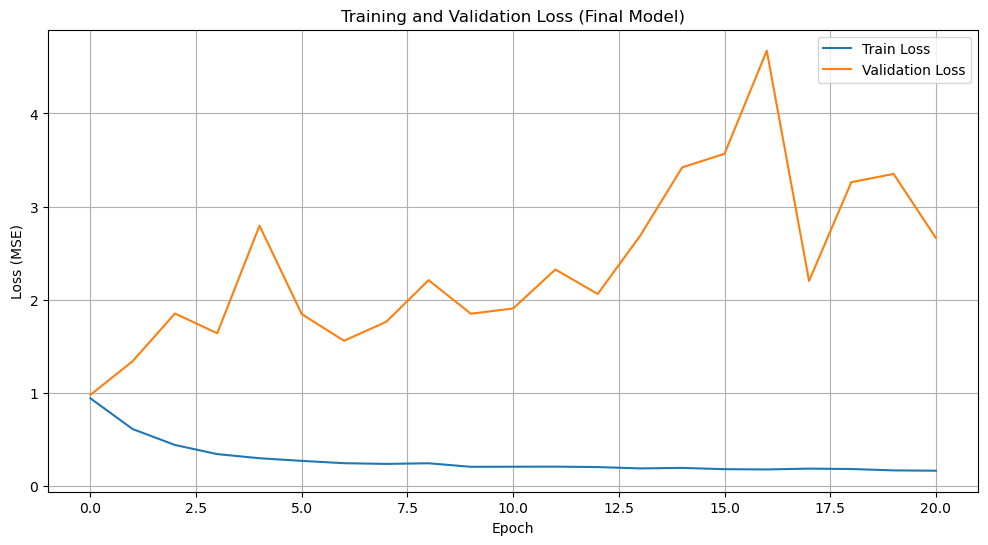

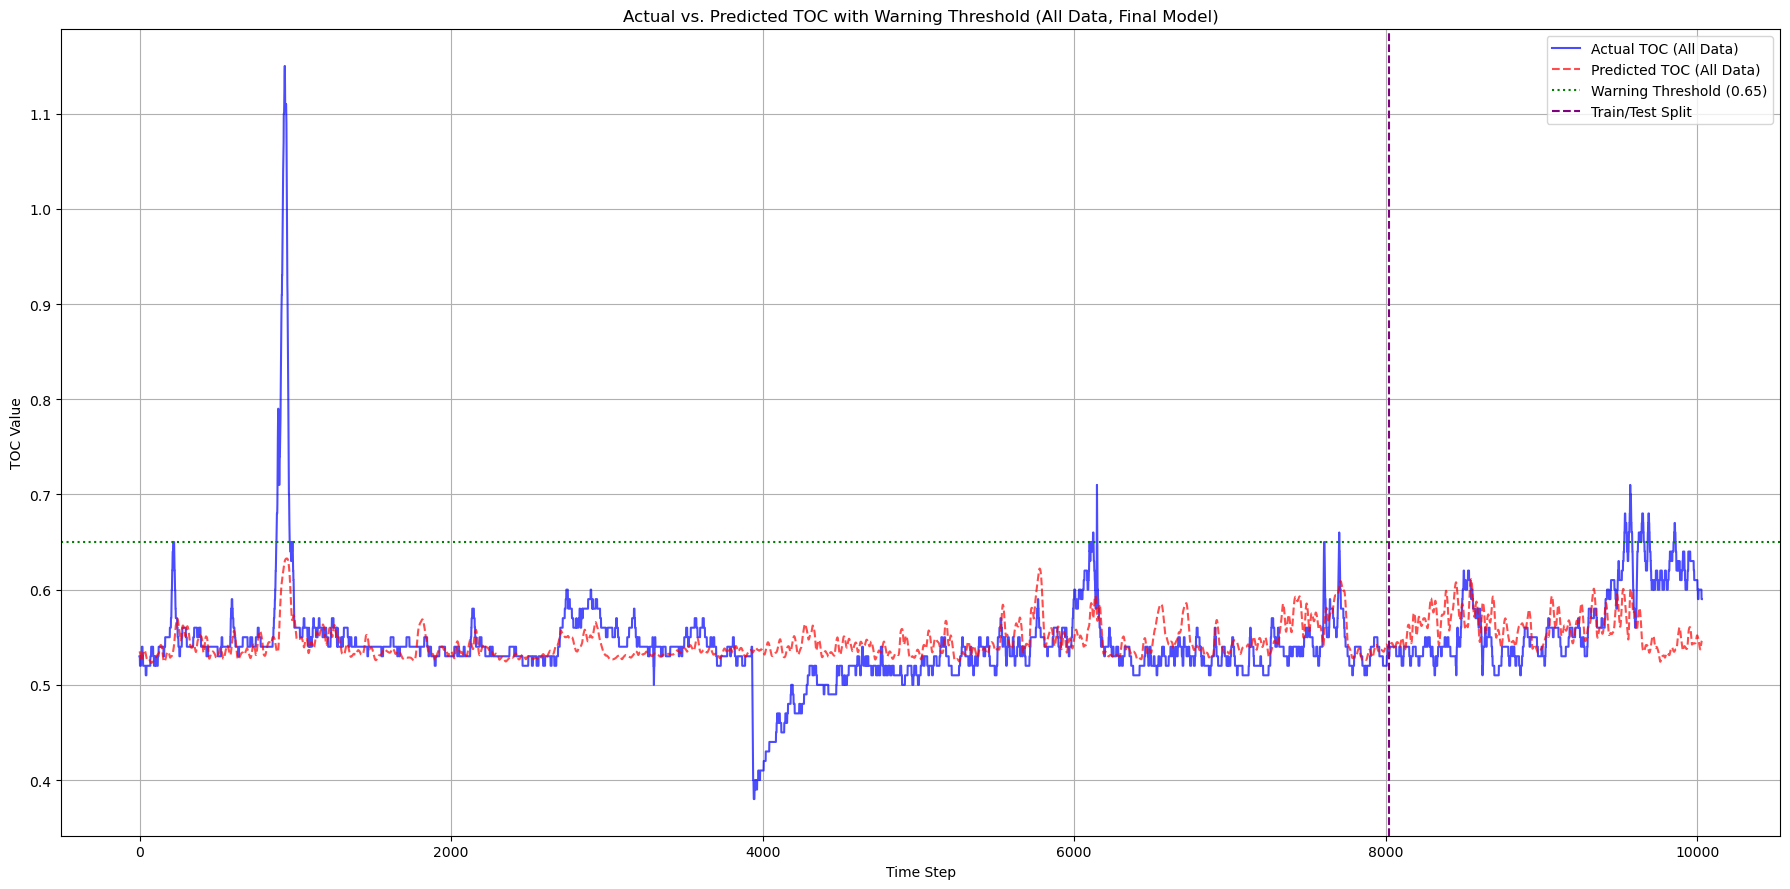

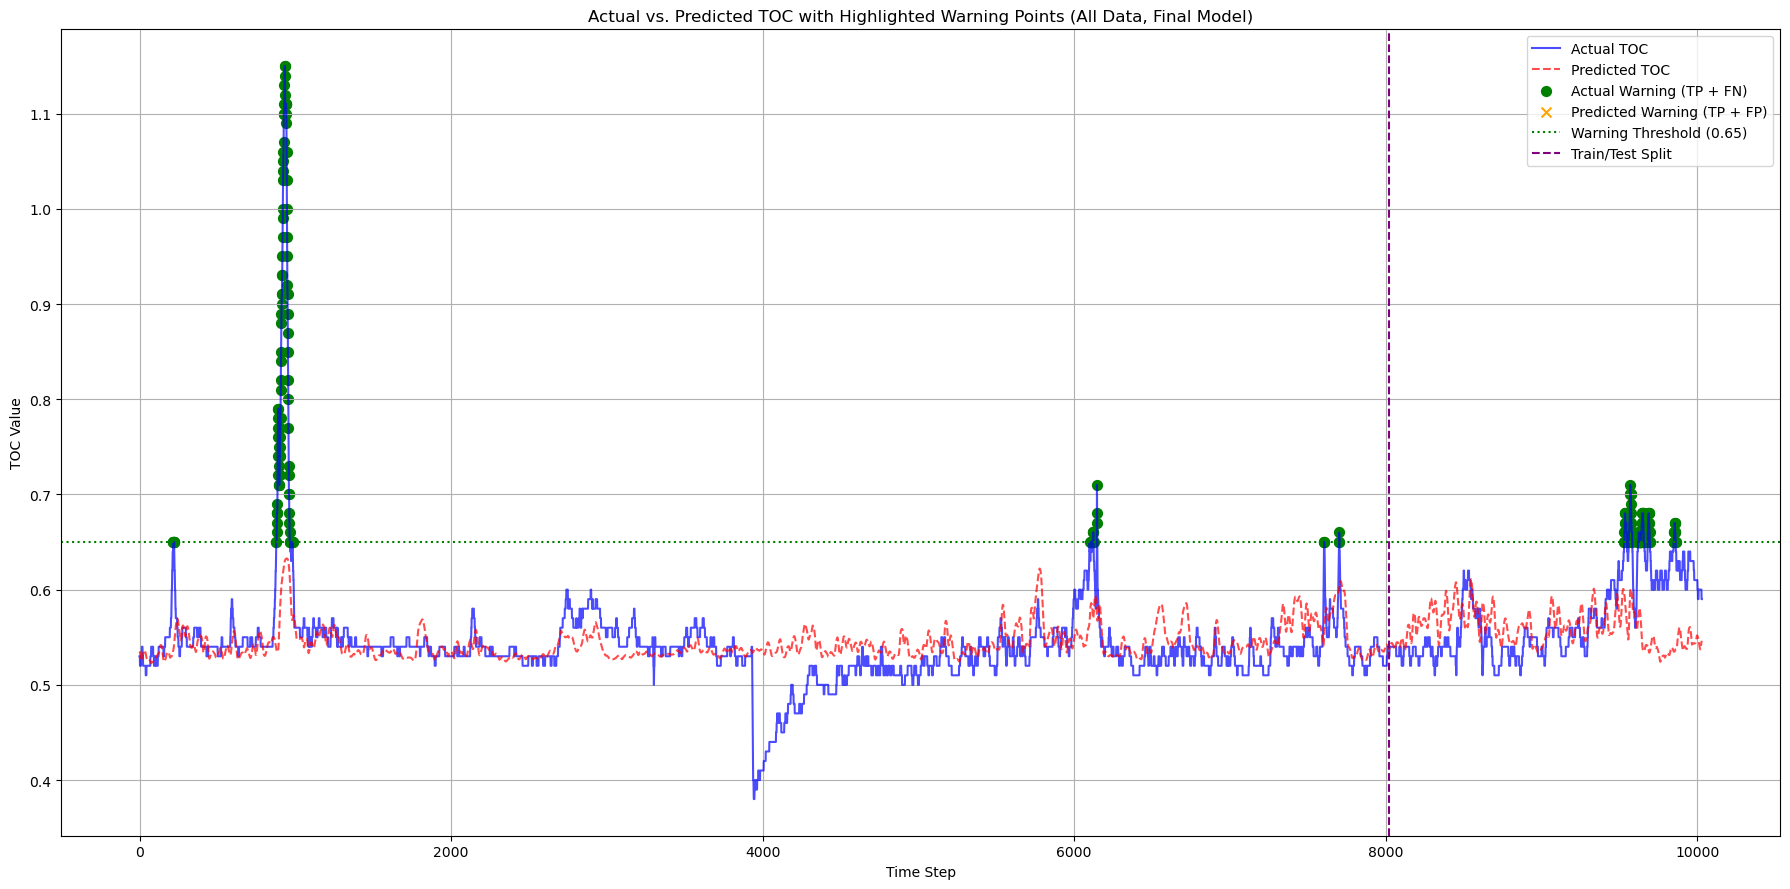

In [12]:
# --- 10. 可视化结果 (使用最终模型和最终训练历史) ---
# 绘制训练/验证损失曲线
plt.figure(figsize=(12, 6))
plt.plot(train_losses_final, label='Train Loss')
plt.plot(val_losses_final, label='Validation Loss')
plt.title('Training and Validation Loss (Final Model)')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(CONFIG['results_dir'], 'final_model_training_validation_loss.png'))
plt.show()

# 对整个数据集进行预测 (使用 final_model)
# 这部分代码与之前相同，只是现在使用 final_model
full_scaled_data = np.vstack((train_scaled, test_scaled))
full_dataset = TOCDataset(full_scaled_data, input_feature_indices, output_feature_index, CONFIG['sequence_length'], CONFIG['forecast_horizon'])
full_loader = DataLoader(full_dataset, batch_size=CONFIG['batch_size'], shuffle=False)

all_predictions_full = []
all_true_values_full = []

with torch.no_grad():
    for inputs, targets in full_loader:
        inputs, targets = inputs.to(CONFIG['device']), targets.to(CONFIG['device'])
        outputs = final_model(inputs)
        all_predictions_full.extend(outputs.cpu().numpy())
        all_true_values_full.extend(targets.cpu().numpy())

all_predictions_full_denorm = output_feature_scaler.inverse_transform(np.array(all_predictions_full).reshape(-1, 1)).flatten()
all_true_values_full_denorm = output_feature_scaler.inverse_transform(np.array(all_true_values_full).reshape(-1, 1)).flatten()

# 绘制所有数据点的预测结果与真实值对比图
plt.figure(figsize=(18, 9))
plt.plot(all_true_values_full_denorm, label='Actual TOC (All Data)', color='blue', alpha=0.7)
plt.plot(all_predictions_full_denorm, label='Predicted TOC (All Data)', color='red', linestyle='--', alpha=0.7)
plt.axhline(y=CONFIG['warning_threshold'], color='green', linestyle=':', label=f'Warning Threshold ({CONFIG["warning_threshold"]})')
train_split_idx = len(train_dataset)
plt.axvline(x=train_split_idx, color='purple', linestyle='--', label='Train/Test Split')
plt.title('Actual vs. Predicted TOC with Warning Threshold (All Data, Final Model)')
plt.xlabel('Time Step')
plt.ylabel('TOC Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(CONFIG['results_dir'], 'final_model_actual_vs_predicted_toc_all_data.png'))
plt.show()

# 绘制所有数据点的预警触发点
predicted_warnings_full = all_predictions_full_denorm >= CONFIG['warning_threshold']
true_warnings_full = all_true_values_full_denorm >= CONFIG['warning_threshold']

plt.figure(figsize=(18, 9))
plt.plot(all_true_values_full_denorm, label='Actual TOC', color='blue', alpha=0.7)
plt.plot(all_predictions_full_denorm, label='Predicted TOC', color='red', linestyle='--', alpha=0.7)
true_warning_indices_full = np.where(true_warnings_full)[0]
plt.scatter(true_warning_indices_full, all_true_values_full_denorm[true_warning_indices_full],
            color='green', marker='o', s=50, label='Actual Warning (TP + FN)')
predicted_warning_indices_full = np.where(predicted_warnings_full)[0]
plt.scatter(predicted_warning_indices_full, all_predictions_full_denorm[predicted_warning_indices_full],
            color='orange', marker='x', s=50, label='Predicted Warning (TP + FP)')
plt.axhline(y=CONFIG['warning_threshold'], color='green', linestyle=':', label=f'Warning Threshold ({CONFIG["warning_threshold"]})')
plt.axvline(x=train_split_idx, color='purple', linestyle='--', label='Train/Test Split')
plt.title('Actual vs. Predicted TOC with Highlighted Warning Points (All Data, Final Model)')
plt.xlabel('Time Step')
plt.ylabel('TOC Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(CONFIG['results_dir'], 'final_model_warning_points_highlighted_all_data.png'))
plt.show()